Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Predicting influenza occurences

### Before you get started, please read the instructions in this notebook carefully.

## Preliminaries

- Please use only Python **version 3** (3.6+ recommended). It is recommended to install Anaconda or Miniconda. 

- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers.

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Goal

The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2012-2018)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2018).


To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Loading data

### Weather observations

As a first step, we implement the method `load_weather_data()`, which reads all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and returns it.

In [2]:
def load_data_index(filename):
    data = pd.read_csv(filename, sep = ';', usecols = range(1,18))
    data['year'] = pd.DatetimeIndex(data['date']).year
    data['month'] = pd.DatetimeIndex(data['date']).month
    data['week'] = pd.DatetimeIndex(data['date']).week
    data['day'] = pd.DatetimeIndex(data['date']).day
    
    data.set_index(['year', 'month', 'week', 'day'], inplace = True)
    data.sort_values(by = ['year', 'month', 'week', 'day'], inplace = True)
    
    final_data = data
    return final_data

In [3]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """

    list_of_obs = []
    filenames = ['../data/weather-corrected/2009-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2010-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2011-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2012-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2013-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2014-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2015-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2016-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2017-ZAMG_Jahrbuch.csv'
                ,'../data/weather-corrected/2018-ZAMG_Jahrbuch.csv']
    
    for x in filenames:
        data = load_data_index(x)
        list_of_obs.append(data)
    weather_data = pd.concat(list_of_obs)
    
    return weather_data

data_weather = load_weather_data()

### Influenza infections

Then, we load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis.

In [4]:
def load_influenza_data():
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    
    column_names = ['Jahr', 'Kalenderwoche', 'Neuerkrankungen pro Woche']
    data = pd.read_csv('../data/influenza/influenza.csv', usecols=column_names)
    influenza_data = data.rename(columns={'Jahr':'year'
                                         ,'Kalenderwoche':'week'
                                         ,'Neuerkrankungen pro Woche':'weekly_infections'})
    influenza_data['week'] = influenza_data['week'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
    influenza_data.set_index(['year', 'week'], inplace=True)
    
    influenza_data = influenza_data[influenza_data['weekly_infections'] != '-']
    influenza_data['weekly_infections'] = influenza_data['weekly_infections'].astype(int)
    
    return influenza_data

data_influenza = load_influenza_data()

## Handling Missing Values

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values.

In [5]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    #replacing null temperature values with median
    #
    incomplete_data["temp_7h"].fillna(incomplete_data["temp_dailyMean"]-1.9, inplace = True)
    incomplete_data["temp_14h"].fillna(incomplete_data["temp_dailyMean"]+2.7, inplace = True)
    incomplete_data["temp_19h"].fillna(incomplete_data["temp_dailyMean"]+0.4, inplace = True)
    
    #replacing null humidity values with mean
    #
    incomplete_data["hum_7h"].fillna(float(80.29), inplace = True)
    incomplete_data["hum_14h"].fillna(float(61.82), inplace = True)
    incomplete_data["hum_19h"].fillna(float(70.08), inplace = True)
    
    #replacing null precipitation values ('Spuren') with median
    #
    incomplete_data['precip'].replace('Spuren', 0.4, inplace = True)
    incomplete_data['precip'] = incomplete_data['precip'].astype(float)
    
    complete_data = incomplete_data
    return complete_data


#bool_series = pd.notnull(incomplete_data['temp_7h'])
#incomplete_data = incomplete_data[bool_series]
#incomplete_data = incomplete_data[incomplete_data['temp_7h'] > -40]
#incomplete_data['new'] = np.where(1, abs(incomplete_data['temp_7h'])-abs(incomplete_data['temp_dailyMean']), 1)
#incomplete_data = incomplete_data['new'].median()
#    
#temp_7h  mean -0.86  median -1.9
#temp_14h mean  4.1   median  2.7
#temp_19h mean  1.6   median  0.4

#incomplete_data = incomplete_data[incomplete_data['precip'] != 'Spuren']
#incomplete_data['precip'] = incomplete_data['precip'].astype(float)
#mean = incomplete_data['precip'].mean()
#
#precip mean 2.3 median 0.4

#incomplete_data['hum_19h'] = incomplete_data['hum_19h'].astype(float)
#mean = incomplete_data['hum_19h'].mean()
#
#hum_7h mean 80.29
#hum_14h mean 61.82
#hum_19h mean 70.08

def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return complete_data
    
data_weather_complete = handle_missingValues_simple(data_weather)

##  Handling Outliers

In [6]:
def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    #replacing temperature outliers with median for each column
    #columns 'temp_dailyMax' and 'temp_dailyMean' did not have any visible outliers
    #
    noisy_data['temp_7h'] = np.where(np.logical_and(noisy_data['temp_7h'] > -40
                                                   ,noisy_data['temp_7h'] < 40), noisy_data['temp_7h'], -1.9)
    noisy_data['temp_14h'] = np.where(np.logical_and(noisy_data['temp_14h'] > -40
                                                   ,noisy_data['temp_14h'] < 40), noisy_data['temp_14h'], 2.7)
    noisy_data['temp_19h'] = np.where(np.logical_and(noisy_data['temp_19h'] > -40
                                                   ,noisy_data['temp_19h'] < 40), noisy_data['temp_19h'], 0.4)
    noisy_data['temp_dailyMin'] = np.where(np.logical_and(noisy_data['temp_dailyMin'] > -13
                                                         ,noisy_data['temp_dailyMin'] < 24), noisy_data['temp_dailyMin'], 8.2)
    #replacing humidity outliers with mean for each column
    #
    noisy_data['hum_7h'] = np.where(noisy_data['hum_7h'] > 45, noisy_data['hum_7h'], 80.29)
    noisy_data['hum_14h'] = np.where(noisy_data['hum_14h'] >= 25, noisy_data['hum_14h'], 61.82)
    noisy_data['hum_19h'] = np.where(noisy_data['hum_19h'] > 30, noisy_data['hum_19h'], 70.08)
    
    #replacing wind outliers with number 3, which represents a small breeze level of wind
    #
    noisy_data['windBeauf_7h'] = np.where(noisy_data['windBeauf_7h'] <=5, noisy_data['windBeauf_7h'], 3)
    noisy_data['windBeauf_14h'] = np.where(np.logical_and(noisy_data['windBeauf_14h'] >= 1
                                                         ,noisy_data['windBeauf_14h'] <= 6), noisy_data['windBeauf_14h'], 3)
    noisy_data['windBeauf_19h'] = np.where(noisy_data['windBeauf_19h'] <= 5, noisy_data['windBeauf_19h'], 3)
    
    #replacing precipitation outliers with mean for each column
    #
    noisy_data['precip'] = np.where(noisy_data['precip'] <= 40, noisy_data['precip'], 0.4)
    
    
#temp_dailyMin median 8.2
#temp_dailyMean median 12.3
#temp_dailyMax median 16.3
    
    cleaned_data = noisy_data
    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)

## Aggregate values

We aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: mean of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

In [7]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    weekly_weather_data = pd.DataFrame()
    
    data['hum_dailyMean'] = (data['hum_7h'] + data['hum_14h'] + data['hum_19h'])/3
    
    tmp_data = data['temp_dailyMin'].groupby(by = ['year','week'], level = ['year','week']).min()
    weekly_weather_data['temp_weeklyMin'] = tmp_data

    tmp_data = data['temp_dailyMax'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['temp_weeklyMax'] = tmp_data

    tmp_data = data['temp_dailyMean'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['temp_weeklyMean'] = tmp_data

    tmp_data = data['temp_7h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_7h_weeklyMedian'] = tmp_data

    tmp_data = data['temp_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_14h_weeklyMedian'] = tmp_data

    tmp_data = data['temp_19h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['temp_19h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_dailyMean'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['hum_weeklyMean'] = tmp_data

    tmp_data = data['hum_7h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_7h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_14h_weeklyMedian'] = tmp_data

    tmp_data = data['hum_19h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['hum_19h_weeklyMedian'] = tmp_data

    tmp_data = data['precip'].groupby(by = ['year','week'], level = ['year','week']).mean()
    weekly_weather_data['precip_weeklyMean'] = tmp_data

    tmp_data = data['windBeauf_14h'].groupby(by = ['year','week'], level = ['year','week']).median()
    weekly_weather_data['windBeauf_14h_weeklyMedian'] = tmp_data
    
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

## Merging influenza and weather datasets

In [8]:
def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    
    merged_data = influenza_df.join(weather_df, on = ['year', 'week'])
    #merged_data['weekly_infections'] = merged_data['weekly_infections'].astype(int)
    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)

## Visualization

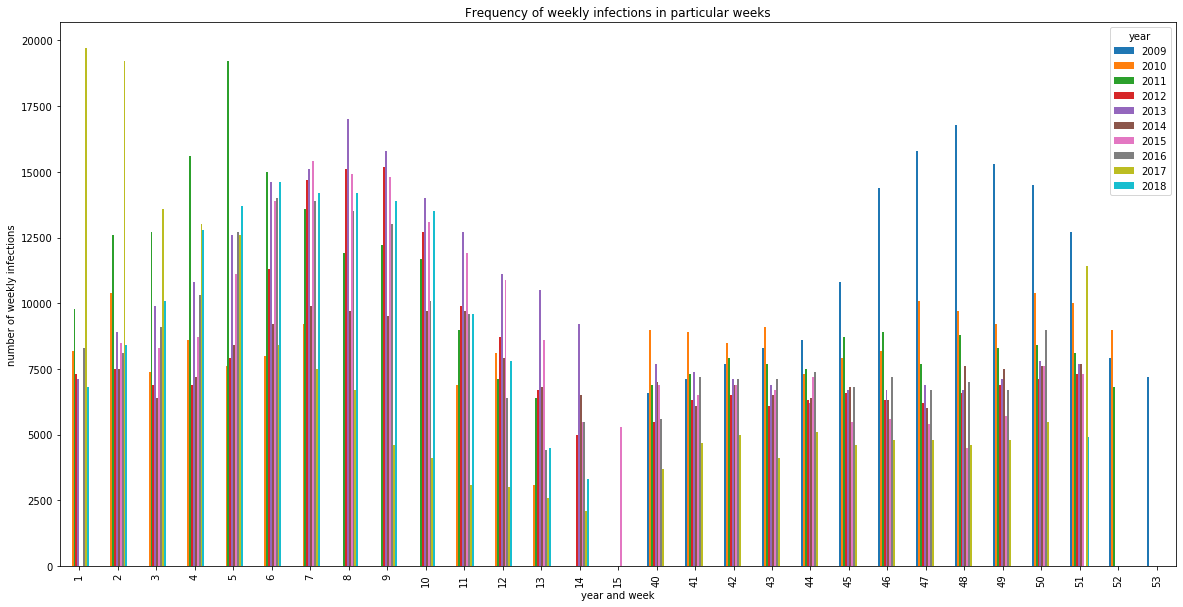

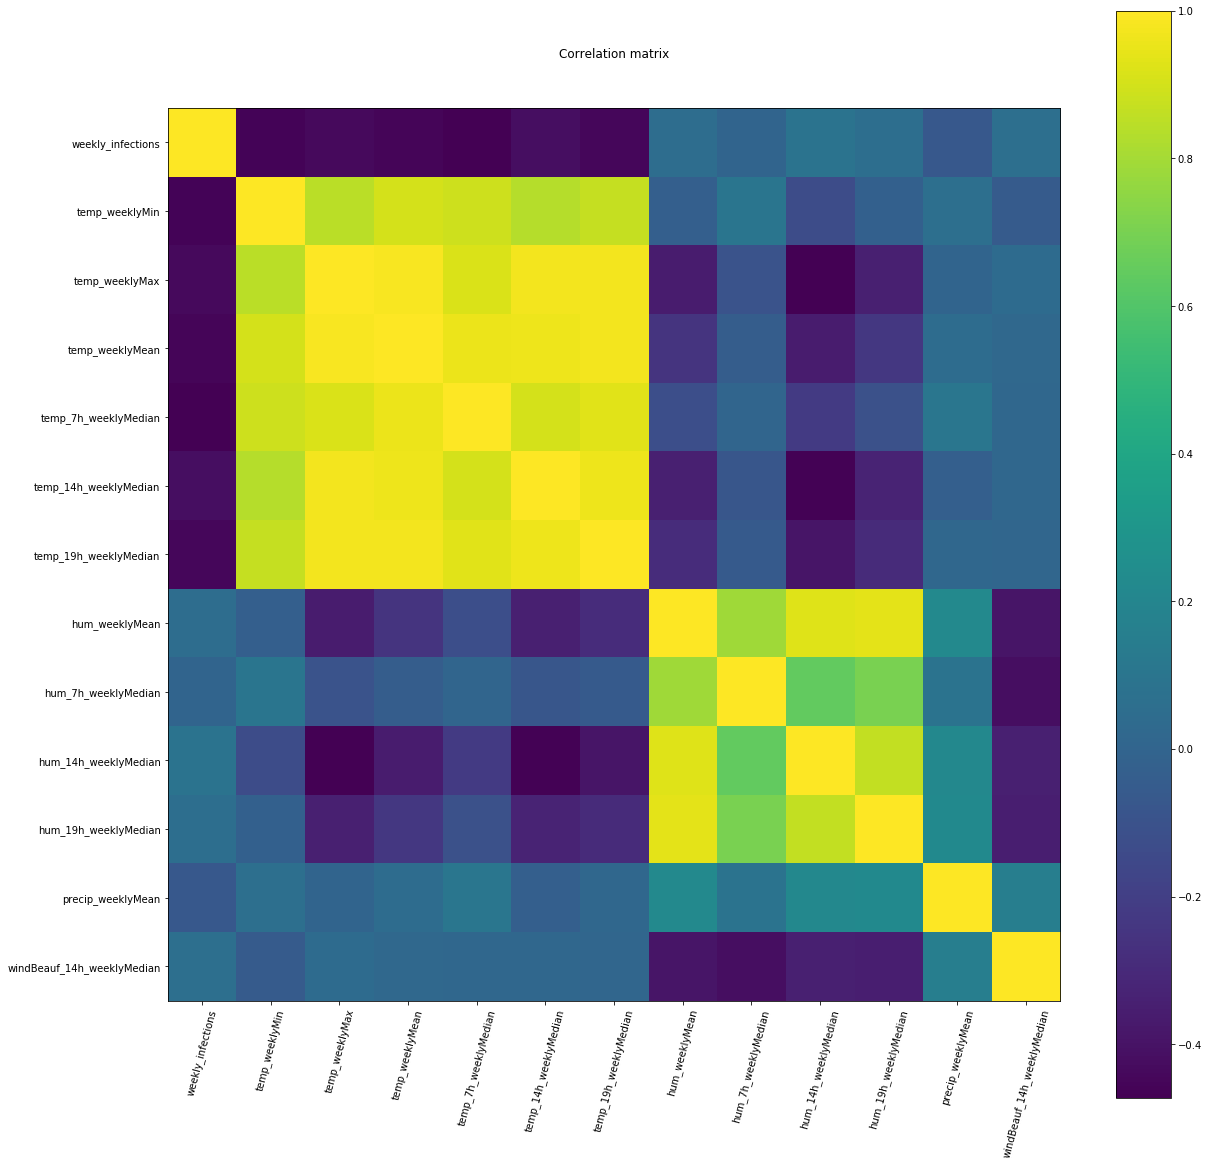

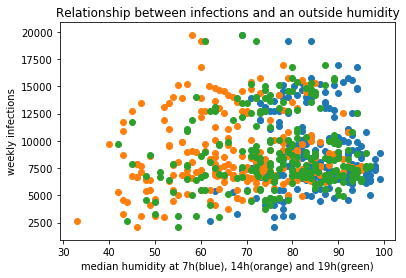

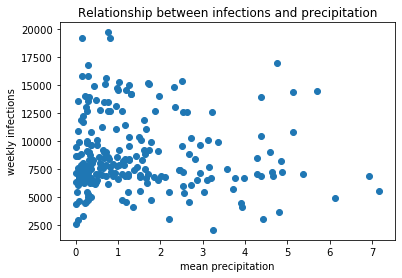

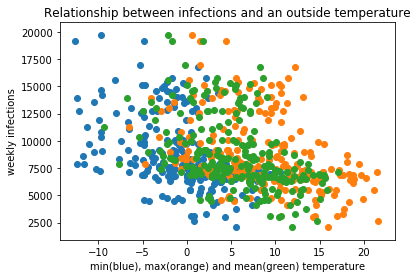

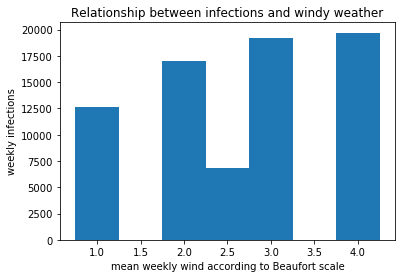

In [9]:

labels = [' ', 'weekly_infections', 'temp_weeklyMin', 'temp_weeklyMax',
       'temp_weeklyMean', 'temp_7h_weeklyMedian', 'temp_14h_weeklyMedian',
       'temp_19h_weeklyMedian', 'hum_weeklyMean', 'hum_7h_weeklyMedian',
       'hum_14h_weeklyMedian', 'hum_19h_weeklyMedian', 'precip_weeklyMean',
       'windBeauf_14h_weeklyMedian']

data_merged.weekly_infections.unstack(level=0).plot(figsize = (20,10), kind='bar')
plt.ylabel('number of weekly infections')
plt.xlabel('year and week')
plt.title('Frequency of weekly infections in particular weeks')
plt.savefig('bar_frequency_weekly_infections' + '_01.png', bbox_inches = 'tight')
plt.show()

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(data_merged.corr(), interpolation='nearest')
fig.colorbar(cax)
ax.xaxis.tick_bottom()
ax.set_xticklabels(labels, rotation = 75)
ax.set_yticklabels(labels)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Correlation matrix')
plt.savefig('heatmap_corr_matrix' + '_02.png', bbox_inches = 'tight')
plt.show()

plt.scatter(data_merged['hum_7h_weeklyMedian'], data_merged['weekly_infections'])
plt.scatter(data_merged['hum_14h_weeklyMedian'], data_merged['weekly_infections'])
plt.scatter(data_merged['hum_19h_weeklyMedian'], data_merged['weekly_infections'])
plt.ylabel('weekly infections')
plt.xlabel('median humidity at 7h(blue), 14h(orange) and 19h(green)')
plt.title('Relationship between infections and an outside humidity')
plt.savefig('scatter_hum_infections' + '_03.png', bbox_inches = 'tight')
plt.show()

plt.scatter(data_merged['precip_weeklyMean'], data_merged['weekly_infections'])
plt.ylabel('weekly infections')
plt.xlabel('mean precipitation')
plt.title('Relationship between infections and precipitation')
plt.savefig('scatter_precip_infections' + '_04.png', bbox_inches = 'tight')
plt.show()

plt.scatter(data_merged['temp_weeklyMin'], data_merged['weekly_infections'])
plt.scatter(data_merged['temp_weeklyMax'], data_merged['weekly_infections'])
plt.scatter(data_merged['temp_weeklyMean'], data_merged['weekly_infections'])
plt.ylabel('weekly infections')
plt.xlabel('min(blue), max(orange) and mean(green) temperature')
plt.title('Relationship between infections and an outside temperature')
plt.savefig('scatter_temp_infections' + '_05.png', bbox_inches = 'tight')
plt.show()

plt.bar(data_merged['windBeauf_14h_weeklyMedian'], data_merged['weekly_infections'], width = 0.5)
plt.ylabel('weekly infections')
plt.xlabel('mean weekly wind according to Beaufort scale')
plt.title('Relationship between infections and windy weather')
plt.savefig('scatter_windBeauf_infections' + '_06.png', bbox_inches = 'tight')
plt.show()

## Influenza prediction model

In [10]:
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from scipy import stats

column_names = ['Jahr', 'Kalenderwoche', 'Neuerkrankungen pro Woche']
data = pd.read_csv('../data/influenza/influenza_predict.csv', usecols=column_names)
influenza_predict_data = data.rename(columns={'Jahr':'year'
                                             ,'Kalenderwoche':'week'
                                             ,'Neuerkrankungen pro Woche':'weekly_infections'})
influenza_predict_data['week'] = influenza_predict_data['week'].apply(lambda x: int(''.join(filter(str.isdigit, x))))
influenza_predict_data.set_index(['year', 'week'], inplace=True)
influenza_predict_data['weekly_infections'] = influenza_predict_data['weekly_infections']*1000
influenza_predict_data['weekly_infections'] = influenza_predict_data['weekly_infections'].astype(int)

data_merged_predict = merge_data(data_weather_weekly, influenza_predict_data)

target_column = ['weekly_infections']
predictors = list(set(list(data_merged.columns))-set(target_column))
data_merged[predictors] = stats.zscore(data_merged[predictors])
#data_merged.describe()

X = data_merged[predictors].values
y = data_merged[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
#print(X_train.shape); print(X_test.shape)

####Support vector regression
#
svr = SVR(kernel = 'rbf', C=10000, gamma='auto', epsilon = 100)
svr.fit(X_train, y_train.ravel()) 
pred_train_svr= svr.predict(X_train)

pred_test_svr= svr.predict(X_test)
print("RMSE of testing data for SVR:\t",np.sqrt(mean_squared_error(y_test,pred_test_svr))) 
print("R2 of testing data  for SVR:\t",r2_score(y_test, pred_test_svr))

pred_final_data_svr = svr.predict(data_merged_predict[predictors])
print("Train:\n", pred_train_svr)
print("\nTest:\n", pred_test_svr)
print("\nFinal prediction:\n", pred_final_data_svr)

RMSE of testing data for SVR:	 1830.8321250369545
R2 of testing data  for SVR:	 0.4278260020985366
Train:
 [ 9599.99745348  9058.7528682   7078.51529813  6799.99977115
 10200.00072509  7445.72095434 10194.20746598  8549.92412578
  8370.33018689  7000.00077218 11110.15427698  9602.28396844
  9514.34482429  9238.72619793  7669.04906579  9300.00075935
  8579.98559179 11863.77008124  9010.21949247 11921.50091654
  7819.23413456 11368.75990376  6799.99984286  9603.90874911
 10699.99938666  6781.21276375  6499.9984853   6735.91610922
 10089.4325394   8311.13850482  6800.00071672  5228.23713497
  7699.99857422 11137.38143436 11600.0016725  11625.95466831
  6400.00014325  8799.99746765  7200.00115609  6199.99931406
  6815.598171    7337.74620654  6515.99565315  3800.00015239
  8029.63465476 11199.99967885  9199.99843147  5299.99961615
  4199.99984704 10283.38007781  8684.03011174  6599.99959441
  8000.00005971 10066.34976763  8423.93137984  6666.17946853
  8700.00048009  8432.19192668  7200.00

## Findings:
   For the evaluation metrics, I used Root mean square error and R-squared score. For SVR, the best combination of parameters appears to be radial basis function kernel with regularization parameter 10000 and epsilon set on 100. Linear kernel is also worth mentioning, but it had slightly worse performance than RBF. When it comes to features, I tried prediction without normalization, which was, naturally the worst. The best result that we were was able to get, is:

RMSE for SVR:     1830.8321250369565
R2 for SVR:         0.4278260020985353

When I applied the prediction algorithm on the 'influenza_predict.csv' data, the algorithm gave us poor results. The only thing that makes sense here, is that the model is not very good - it's possible that the data is still not clean enough.